In [92]:
import math

In [136]:
# we will be coding a graph to viz the basic math functio9n sand ops

#we iwll define  aclass vals
class vals:
    #now we want to know what vals tougether geretated theres 100 in this case
    #we will maintain  a tuple to handel this
    def __init__(self,data,_children=(),_ops='',_label=''):

        self.data = data
        #we pass it into a set so that thge space is effciently utilized
        self._prev = set(_children)
        self._ops = _ops
        self._label = _label
        self.grad = 0.0
        #define backprop
        self._backprop = lambda: None

    def __repr__(self):
        #prints out the data
        return  f"the data is {self.data} "

    #adds 2 vals
    def __add__(self, other):

        d =  vals(self.data + other.data, (self,other),'+')    
        #definiation of derivatives for addition
        def _backprop():
            self.grad = 1.0 * d.grad #cause diffrentiation with self is a one
            other.grad = 1.0 * d.grad

        #this is like a way to overwrite the global var declaration through func calls
        d._backprop = _backprop
        return d

    #muls 2 vals
    def __mul__(self, other):

        d =  vals(self.data * other.data, (self,other),'*')          
        #definiation of derivatives for muls
        def _backprop():
            #this makes sense for a multipicative operation
            self.grad = d.grad * other.data
            other.grad = d.grad * self.data
        
        d._backprop = _backprop
        return d

    #here we define tanh although this can be atomically implemented using the "e" solely to keep the defination simple
    def tanh(self):
        #treat it as tanh(x)
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        #we return the params pof val class ie.. t would be data 'tanh' will be the ops and so on, so its more like calling the activation on self
        res = vals(t, (self,), 'tanh')
        def _backprop():
            #this makes sense for a tanh operation
            self.grad = (1- t**2)* res.grad  

        res._backprop = _backprop
        return res
    

a = vals(2.0, _label='a')
b = vals(-3.0, _label='b')
c = vals(10.0, _label='c')
e = a*b ;e._label = 'e'
d = e+c ;d._label = 'd'
f = vals(-2.0, _label='f')
L = d*f ;L._label = 'L'

THIS IS TO CALCULATE THE GRADIENTS: (only for the L func ..we will generalise this later)

In [94]:
def calculate_grad(node): #this depecits d(L1)/d(x)

    # x = node._label
    # #this is the samll val h wrtto which we cal gradient 
    # h = 0.0001 
    # #we wil def local vars
    # a1=a.data
    # b1=b.data
    # c1=c.data
    # d1=d.data
    # e1=e.data
    # f1=f.data

    # #we will cal the bump
    # if(x=='a'):
    #     a1 = a1 + h
    # if(x=='b'):
    #     b1 = b1 + h
    # if(x=='c'):
    #     c1 = c1 + h
    # if(x=='d'):
    #     d1 = d1 + h
    # if(x=='e'):
    #     e1 = e1 + h
    # if(x=='f'):
    #     f1 = f1 + h

    # L1 = L.data
    # #now we need to cal L2
    # e1 = a1*b1 
    # d1 = e1+c1 
    # L2 = d1*f1 

    # grad = (L2-L1)/h
    # return grad

    #well now we can make this code more efficient
    h = 1e-4
    #keeps labels and nodes together
    val = {'a':a , 'b':b , 'c':c , 'd':d, 'e':e , 'f':f , 'L':L}
    #this maps the smae keys with the data vals
    values = {k: v.data for k,v in val.items() }

    #this is bump
    if node._label == 'a' or 'b' or 'c' or 'f':
        values[node._label] += h
    #anything with  write should only be bumped after the write

    values['e'] = values['a']* values['b']
    if node._label == 'e':
        values[node._label] += h

    values['d'] = values['e'] + values['c']
    if node._label == 'd':
        values[node._label] += h

    if node._label == 'L':
        values[node._label] += h
        L2 = L.data + h
    else:
        L2 = values['d']* values['f']


    L1 = L.data
    return (L2-L1)/h

In [95]:
i =  calculate_grad(L)
print(i)

0.9999999999976694


GENERATE THE GRAPH USING GRAPVIZ:

In [116]:
# now we can code an expressioin graph out 
#we will use the graphviz lib
from graphviz import Digraph

#this will populate the nodes and edges set by usingDFS
def trace(root):

    nodes,edges = set(),set()
    #his reccursive function will do thetraversal
    def recc(v):

        if v not in nodes:
            #we add the ele not the visited set 
            nodes.add(v)
            for n in v._prev:
                #add the edges to the set
                edges.add((n,v))
                #call the recc function
                recc(n)

    recc(root)
    return nodes,edges



def create_graph(root):

    #this derfines the export format of the graph and also how irts aligned
    make = Digraph(format= 'svg', graph_attr= {'rankdir':'LR'})

    nodes,edges = trace(root)

    for n in nodes:

        # #we will caluculate the grads here
        # n_grad = calculate_grad(n)

        uid = str(id(n))
        # make.node(name= uid, label= "{%s | data= %.4f | gradient= %.4f}"% (n._label, n.data, n_grad ), shape= 'record' )
        make.node(name= uid, label= "{%s | data= %.4f | gradient= %.4f}"% (n._label, n.data, n.grad), shape= 'record' )

        if n._ops:
            #we will create a dummy node if its an op
            make.node(name= uid+n._ops, label= (n._ops))
            make.edge(uid+n._ops, uid)

    for n1, n2 in edges:

        make.edge(str(id(n1)), str(id(n2)) + n2._ops  )

    return make

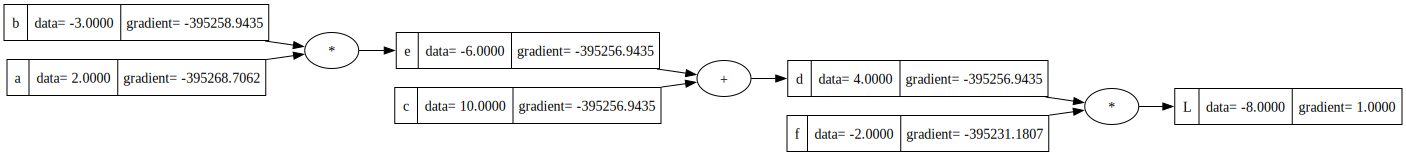

In [112]:
create_graph(L)

NOW WE WILL TRY'NA CREATE A NURAL NET

In [98]:
import numpy as np 
import matplotlib.pyplot as plt

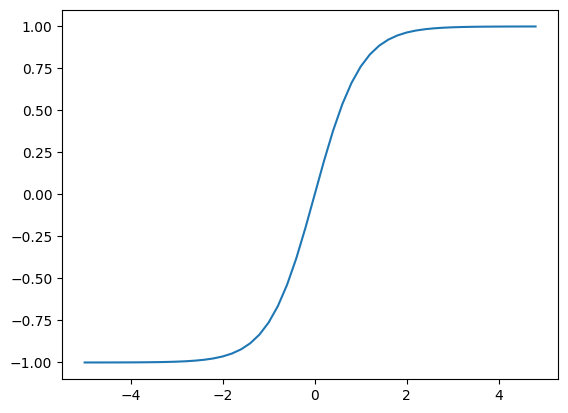

In [99]:
#this is  tanh activation function from numpy that we'll be using
arr = np.arange(-5,5,0.2)
plt.plot(arr, np.tanh(arr))

In [142]:
#now we will write a nural net by initalising weight biases and inputs from the class vals we created

#inputs x1, x2
x1 = vals(2.0, _label='x1')
x2 = vals(0.0, _label='x2')
#weights w1, w2
w1 = vals(-3.0, _label='w1')
w2 = vals(1.0, _label='w2')
#bias
b = vals(6.8813735870195432, _label='b')
#we take the dot product of the inputs agianst weights to get the vector
x1w1 = x1 * w1 ; x1w1._label = 'x1w1'
x2w2 = x2 * w2 ; x2w2._label = 'x2w2'
#this corresponds to [inputs]*[weights] ;we add these
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2._label = 'x1w1x2w2'
#we add the bias(b) to the vector
res = x1w1x2w2 + b ; res._label = 'n'
o = res.tanh() ; o._label = 'o'



In [146]:
#for now we manually define the grads
o.grad = 1.0
#the local derivative of the tan function using 1- tanh()**2
# print(1-(o.data)**2) ~0.5 so using this
res.grad = 0.5
#now coming to the addition treat it as d(tanh(&))/d(b) {& = x1w1x2w2 + b}
#tanh'(&)*&' and this evals to 0.5(from prev res)*&' => &' = (x1w1x2w2 + b)' which evals to one in either case 
x1w1x2w2.grad = 0.5
b.grad = 0.5
#backpropiing similarly yilds us
x1w1.grad = 0.5
x2w2.grad = 0.5
#now that we finally have and * ops we get dependece
x1.grad = 0.5*-3.0 #this is bec's 0.5*(x1w1)' = 0.5*(w1)
w1.grad = 0.5*2.0 # 0.5*(x1)
x2.grad = 0.5*1.0 #similarly
w2.grad = 0.5*0.0


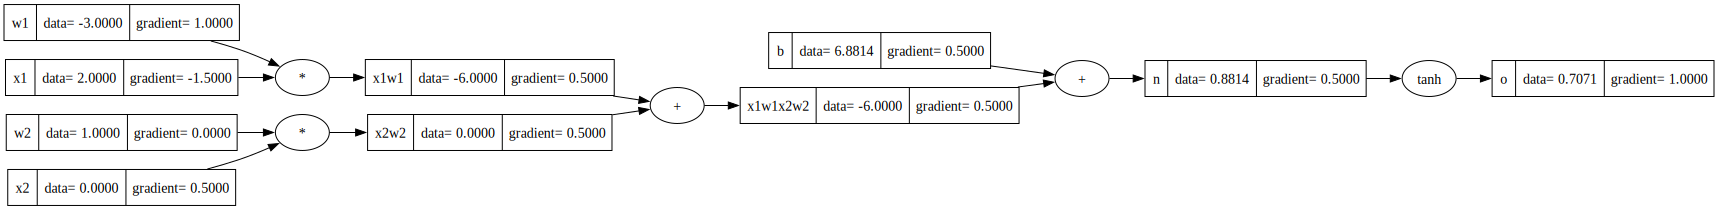

In [147]:
create_graph(o)

NOW THAT WE HAVE DEFINED THE GRADS ABOVE IN THE CLASS( propogate backwards )

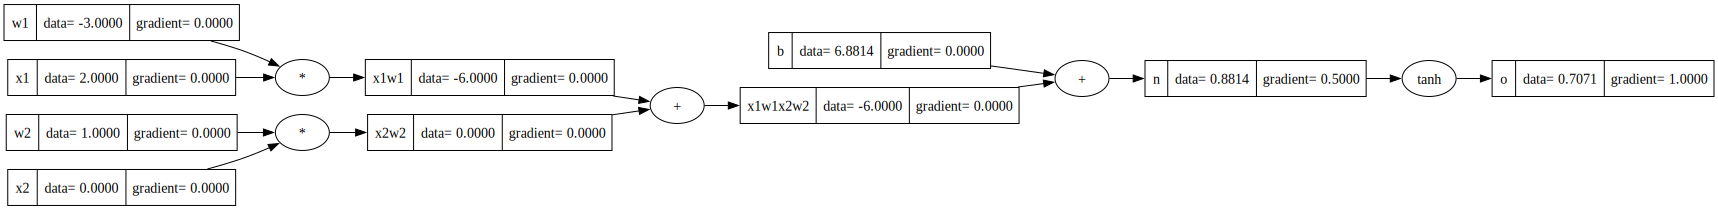

In [145]:
#for the base case we define the grad as 1
o.grad = 1.0
o._backprop()
#and similarly we can call the backprop for all these ndoes
#so the idea is     ------> '''''''       to propogate backward      ''''''''''
create_graph(o)#now we see the grad of'n' go from 0 to 0.5 


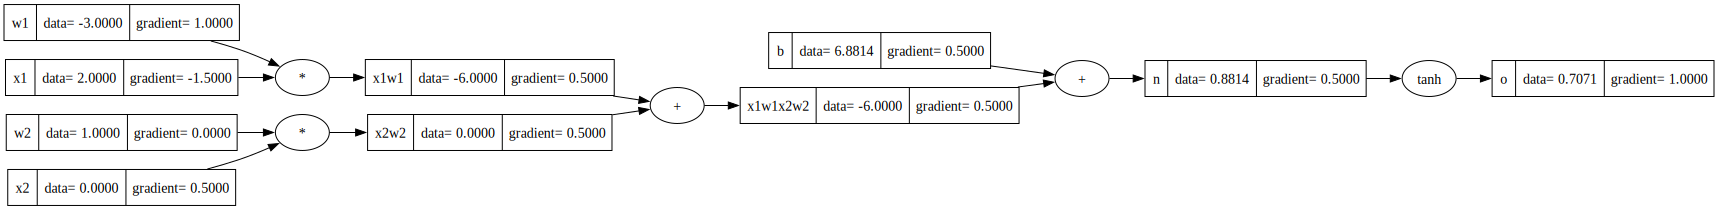

In [152]:
# now automating the same with the trace function we defiend backthen
nodes,edges  = trace(o) #althoh you can write a topological sort with just nodes for efficiency ie vomitting set edges
for node in nodes:
    node._backprop()
create_graph(o)
